<a href="https://colab.research.google.com/github/SheYuting/ece4010project/blob/main/MovieRecommendationSys.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data Processing**

In [2]:
import pandas as pd
import numpy as np
import scipy.stats
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

In [3]:
ratings=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/ratings.csv")

In [4]:
ratings.head(5)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [5]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [6]:
movies = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/movies.csv")

In [7]:
movies.head(5)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


# **Visualisation**

In [8]:
df = pd.merge(ratings, movies, on="movieId", how ='inner')
df.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [9]:
agg_ratings = df.groupby('title').agg(mean_rating = ('rating', 'mean'), number_of_ratings = ('rating','count'))
agg_ratings_GT100 = agg_ratings[agg_ratings['number_of_ratings']>100]
agg_ratings_GT100.info()

<class 'pandas.core.frame.DataFrame'>
Index: 134 entries, 2001: A Space Odyssey (1968) to X-Men (2000)
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   mean_rating        134 non-null    float64
 1   number_of_ratings  134 non-null    int64  
dtypes: float64(1), int64(1)
memory usage: 3.1+ KB


In [10]:
agg_ratings_GT100.sort_values(by = 'number_of_ratings', ascending = False).head()

,mean_rating,number_of_ratings
title,,
Forrest Gump (1994),4.164134,329
"Shawshank Redemption, The (1994)",4.429022,317
Pulp Fiction (1994),4.197068,307
"Silence of the Lambs, The (1991)",4.161290,279
"Matrix, The (1999)",4.192446,278


In [11]:
import plotly.express as px
movie_stats = df.groupby('movieId').agg({'rating': ['mean', 'count']})
movie_stats.columns = movie_stats.columns.droplevel(0)
movie_stats = movie_stats.rename(columns={'mean': 'mean_rating', 'count': 'rating_count'})
movie_stats = movie_stats[movie_stats['rating_count'] >= 50].iloc[:200, :]
fig = px.scatter(movie_stats, x='mean_rating', y='rating_count', hover_name=movie_stats.index, size='rating_count',
                 color='mean_rating',
                 labels={'mean_rating': 'Mean Rating', 'rating_count': 'Rating Count'}, title='Movie Ratings')
fig.show()

In [12]:
user_stats = df.groupby('userId').agg({'rating': ['mean', 'count']})
user_stats.columns = user_stats.columns.droplevel(0)
user_stats = user_stats.rename(columns={'mean': 'mean_rating', 'count': 'rating_count'})
user_stats = user_stats[user_stats['rating_count'] >= 50].iloc[:100, :]
fig = px.scatter(user_stats, x='mean_rating', y='rating_count', hover_name=user_stats.index, size='rating_count',
                 color='mean_rating',
                 labels={'mean_rating': 'Mean Rating', 'rating_count': 'Rating Count'}, title='User Ratings')
fig.show()

In [13]:
rating_val_count = df.rating.value_counts()
fig = px.bar(rating_val_count, x=rating_val_count.index, y=rating_val_count, text=rating_val_count,
             labels={
                 "index": "Ratings",
                 'y': 'Number of Ratings'},
             color=rating_val_count
             )
fig.update_traces(textposition='outside')
fig.update_layout(title_text='Frequency of the Ratings',
                  title_x=0.5, title_font=dict(size=24))
fig.update_traces(marker=dict(line=dict(color='#000000', width=2)))
fig.update_layout({'plot_bgcolor': 'rgba(0, 0, 0, 0)'})
fig.show()

# **Prediction Using Deep Neuron Networks**

In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [15]:
user_ids = ratings['userId'].unique().tolist()
item_ids = ratings['movieId'].unique().tolist()

user_to_index = {x: i for i, x in enumerate(user_ids)}
item_to_index = {x: i for i, x in enumerate(item_ids)}
index_to_user = {i: x for x, i in user_to_index.items()}
index_to_item = {i: x for x, i in item_to_index.items()}

ratings['userId'] = ratings['userId'].apply(lambda x: user_to_index[x])
ratings['movieId'] = ratings['movieId'].apply(lambda x: item_to_index[x])

In [16]:
train, test = train_test_split(ratings, test_size=0.2, random_state=42)

# standardise ratings
scaler = StandardScaler()
train['rating'] = scaler.fit_transform(train['rating'].values.reshape(-1, 1))
test['rating'] = scaler.transform(test['rating'].values.reshape(-1, 1))

# set up neural network
n_users = len(user_ids)
n_items = len(item_ids)
n_factors = 50  #number of neurons

user_input = Input(shape=(1,), name='user_input')
user_embedding = Embedding(input_dim=n_users, output_dim=n_factors, name='user_embedding')(user_input)
user_vec = Flatten()(user_embedding)
user_vec = Dropout(0.5)(user_vec)

item_input = Input(shape=(1,), name='item_input')
item_embedding = Embedding(input_dim=n_items, output_dim=n_factors, name='item_embedding')(item_input)
item_vec = Flatten()(item_embedding)
item_vec = Dropout(0.5)(item_vec)

concat = Concatenate()([user_vec, item_vec])
concat = Dense(128, activation='relu')(concat)
concat = BatchNormalization()(concat)
concat = Dropout(0.5)(concat)
concat = Dense(64, activation='relu')(concat)
concat = BatchNormalization()(concat)
concat = Dropout(0.5)(concat)
output = Dense(1)(concat)

model = Model(inputs=[user_input, item_input], outputs=output)
model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

# train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')

history = model.fit(
    [train['userId'], train['movieId']],
    train['rating'],
    epochs=10,
    verbose=1,
    validation_data=([test['userId'], test['movieId']], test['rating']),
    callbacks=[early_stopping, model_checkpoint]
)

# RMSE
predictions = model.predict([test['userId'], test['movieId']])
mse = mean_squared_error(test['rating'], predictions)
rmse = np.sqrt(mse)

print(f'Test RMSE: {rmse}')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 user_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 item_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 user_embedding (Embedding)  (None, 1, 50)                30500     ['user_input[0][0]']          
                                                                                                  
 item_embedding (Embedding)  (None, 1, 50)                486200    ['item_input[0][0]']          
                                                                                              

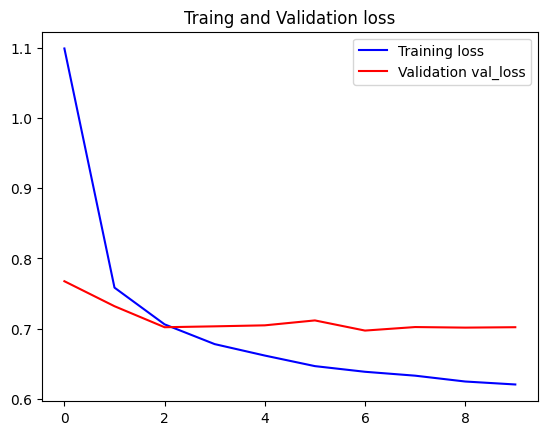

In [17]:
epochs=range(len(history.history['loss']))
plt.figure()
plt.plot(epochs,history.history['loss'],'b',label='Training loss')
plt.plot(epochs,history.history['val_loss'],'r',label='Validation val_loss')
plt.title('Traing and Validation loss')
plt.legend()

# **Prediction Using Linear Regression Model**

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [19]:
# Split the data into training and testing sets
num_recommendations = 5
train_data, test_data = train_test_split(ratings, test_size=0.2, random_state=42)

# Create user and item feature vectors
user_ids = ratings['userId'].unique()
movie_ids = ratings['movieId'].unique()

user_id_map = {user_id: i for i, user_id in enumerate(user_ids)}
movie_id_map = {movie_id: i for i, movie_id in enumerate(movie_ids)}

train_data['user_id'] = train_data['userId'].map(user_id_map)
train_data['movie_id'] = train_data['movieId'].map(movie_id_map)
test_data['user_id'] = test_data['userId'].map(user_id_map)
test_data['movie_id'] = test_data['movieId'].map(movie_id_map)

# Prepare training data
X_train = train_data[['user_id', 'movie_id']]
y_train = train_data['rating']

# Train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Prepare testing data
X_test = test_data[['user_id', 'movie_id']]
y_test = test_data['rating']

# Predict ratings
y_pred = model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Linear Regression RMSE: {rmse}')

Linear Regression RMSE: 1.035231150976587


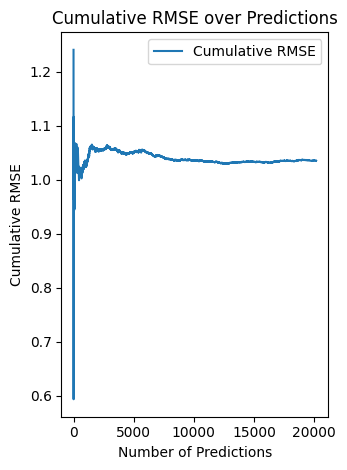

In [22]:
cumulative_rmse = np.sqrt(np.cumsum((y_pred - y_test) ** 2) / np.arange(1, len(y_test) + 1))

plt.subplot(1, 2, 2)
plt.plot(np.arange(1, len(y_test) + 1), cumulative_rmse, label='Cumulative RMSE')
plt.xlabel('Number of Predictions')
plt.ylabel('Cumulative RMSE')
plt.title('Cumulative RMSE over Predictions')
plt.legend()

plt.tight_layout()
plt.show()

# **Item Based & User Based Recommendation**

In [23]:
df_GT100 = pd.merge(df, agg_ratings_GT100,on='title',how = 'inner')
df_GT100.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19788 entries, 0 to 19787
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   userId             19788 non-null  int64  
 1   movieId            19788 non-null  int64  
 2   rating             19788 non-null  float64
 3   timestamp          19788 non-null  int64  
 4   title              19788 non-null  object 
 5   genres             19788 non-null  object 
 6   mean_rating        19788 non-null  float64
 7   number_of_ratings  19788 non-null  int64  
dtypes: float64(2), int64(4), object(2)
memory usage: 1.2+ MB


In [24]:
print('the ratings dataset has', df['userId'].nunique(), 'unique users')
print('the ratings dataset has', df['movieId'].nunique(), 'unique movies')
print('the ratings dataset has', df['rating'].nunique(), 'unique ratings')

the ratings dataset has 610 unique users
the ratings dataset has 9724 unique movies
the ratings dataset has 10 unique ratings


In [25]:
matrix = df_GT100.pivot_table(index = 'userId', columns='title', values ='rating')
matrix.head()

title,2001: A Space Odyssey (1968),Ace Ventura: Pet Detective (1994),Aladdin (1992),Alien (1979),Aliens (1986),"Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)",American Beauty (1999),American History X (1998),American Pie (1999),Apocalypse Now (1979),...,True Lies (1994),"Truman Show, The (1998)",Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Twister (1996),Up (2009),"Usual Suspects, The (1995)",WALL·E (2008),Waterworld (1995),Willy Wonka & the Chocolate Factory (1971),X-Men (2000)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,4.0,NaN,NaN,5.0,5.0,NaN,4.0,...,NaN,NaN,NaN,3.0,NaN,5.0,NaN,NaN,5.0,5.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,4.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,...,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN
5,NaN,3.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN


In [26]:
matrix_norm=matrix.subtract(matrix.mean(axis=1), axis='rows')
matrix_norm.head()

title,2001: A Space Odyssey (1968),Ace Ventura: Pet Detective (1994),Aladdin (1992),Alien (1979),Aliens (1986),"Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)",American Beauty (1999),American History X (1998),American Pie (1999),Apocalypse Now (1979),...,True Lies (1994),"Truman Show, The (1998)",Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Twister (1996),Up (2009),"Usual Suspects, The (1995)",WALL·E (2008),Waterworld (1995),Willy Wonka & the Chocolate Factory (1971),X-Men (2000)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,-0.392857,NaN,NaN,0.607143,0.607143,NaN,-0.392857,...,NaN,NaN,NaN,-1.392857,NaN,0.607143,NaN,NaN,0.607143,0.607143
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,0.617647,NaN,NaN,NaN,1.617647,NaN,NaN,NaN,...,NaN,NaN,-1.382353,NaN,NaN,NaN,NaN,NaN,0.617647,NaN
5,NaN,-0.461538,0.538462,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.461538,NaN,NaN,NaN,NaN,0.538462,NaN,NaN,NaN,NaN


In [27]:
user_similarity=matrix_norm.T.corr()
user_similarity.head(5)

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
userId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,NaN,NaN,0.391797,0.180151,-0.439941,-0.029894,0.464277,1.0,-0.037987,...,0.091574,0.254514,0.101482,-0.500000,0.780020,0.303854,-0.012077,0.242309,-0.175412,0.071553
2,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,...,-0.583333,NaN,-1.000000,NaN,NaN,0.583333,NaN,-0.229416,NaN,0.765641
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.391797,NaN,NaN,1.000000,-0.394823,0.421927,0.704669,0.055442,NaN,0.360399,...,-0.239325,0.562500,0.162301,-0.158114,0.905134,0.021898,-0.020659,-0.286872,NaN,-0.050868
5,0.180151,NaN,NaN,-0.394823,1.000000,-0.006888,0.328889,0.030168,NaN,-0.777714,...,0.000000,0.231642,0.131108,0.068621,-0.245026,0.377341,0.228218,0.263139,0.384111,0.040582


In [28]:
user_similarity_cosine = cosine_similarity(matrix_norm.fillna(0))
user_similarity_cosine

array([[ 1.        ,  0.        ,  0.        , ...,  0.14893867,
        -0.06003146,  0.04528224],
       [ 0.        ,  1.        ,  0.        , ..., -0.04485403,
        -0.25197632,  0.18886414],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.14893867, -0.04485403,  0.        , ...,  1.        ,
         0.14734568,  0.07931015],
       [-0.06003146, -0.25197632,  0.        , ...,  0.14734568,
         1.        , -0.14276787],
       [ 0.04528224,  0.18886414,  0.        , ...,  0.07931015,
        -0.14276787,  1.        ]])

In [29]:
picked_userid=2
user_similarity.drop(axis=0, index=picked_userid, inplace=True)
user_similarity.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
userId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,NaN,NaN,0.391797,0.180151,-0.439941,-0.029894,0.464277,1.0,-0.037987,...,0.091574,0.254514,0.101482,-0.500000,0.780020,0.303854,-0.012077,0.242309,-0.175412,0.071553
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.391797,NaN,NaN,1.000000,-0.394823,0.421927,0.704669,0.055442,NaN,0.360399,...,-0.239325,0.562500,0.162301,-0.158114,0.905134,0.021898,-0.020659,-0.286872,NaN,-0.050868
5,0.180151,NaN,NaN,-0.394823,1.000000,-0.006888,0.328889,0.030168,NaN,-0.777714,...,0.000000,0.231642,0.131108,0.068621,-0.245026,0.377341,0.228218,0.263139,0.384111,0.040582
6,-0.439941,NaN,NaN,0.421927,-0.006888,1.000000,0.000000,-0.127385,NaN,0.957427,...,-0.292770,-0.030599,-0.123983,-0.176327,0.063861,-0.468008,0.541386,-0.337129,0.158255,-0.030567


In [30]:
#choose the top n users like watch similar movies as the chosen user
n = 10
#setting a threshold
user_similarity_threshold = 0.3
similar_users=user_similarity[user_similarity[picked_userid]>user_similarity_threshold][picked_userid].sort_values(ascending=False)[:n]
print(f'The similar users for user {picked_userid} are', similar_users)

The similar users for user 2 are userId
10     1.0
203    1.0
184    1.0
159    1.0
112    1.0
93     1.0
363    1.0
370    1.0
313    1.0
60     1.0
Name: 2, dtype: float64


In [31]:
similar_users.index

Index([10, 203, 184, 159, 112, 93, 363, 370, 313, 60], dtype='int64', name='userId')

In [32]:
picked_userid_watched=matrix_norm[matrix_norm.index==picked_userid].dropna(axis=1, how='all')
picked_userid_watched.values

array([[ 0.5,  0. ,  0. ,  0.5,  0. ,  0. , -1. ]])

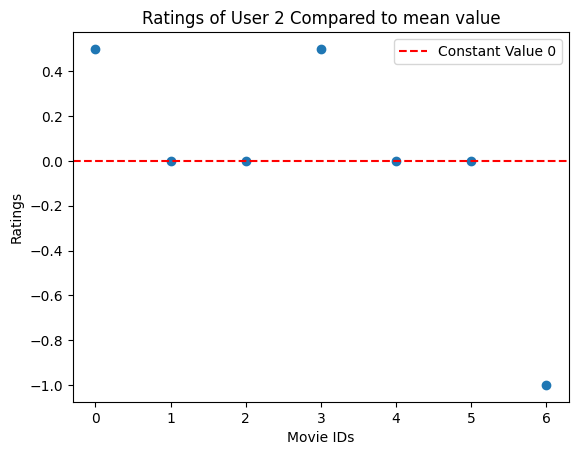

In [33]:
zeros = np.zeros(len(picked_userid_watched.values.tolist()[0]))
indexes = [i for i in range(len(picked_userid_watched.values.tolist()[0]))]
plt.plot(indexes, picked_userid_watched.values.tolist()[0],'o')
plt.axhline(y=0, color='r', linestyle='--', label='Constant Value 0')

# Adding labels and title
plt.xlabel('Movie IDs')
plt.ylabel('Ratings')
plt.title(f'Ratings of User {picked_userid} Compared to mean value')
plt.legend()

# Display the plot
plt.show()

In [34]:
#select the movies that similar users have watched
similar_user_movies=matrix_norm[matrix_norm.index.isin(similar_users.index)].dropna(axis=1,how='all')
similar_user_movies

title,2001: A Space Odyssey (1968),Aladdin (1992),Alien (1979),Aliens (1986),"Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)",American Beauty (1999),American History X (1998),American Pie (1999),Apocalypse Now (1979),Apollo 13 (1995),...,Trainspotting (1996),True Lies (1994),Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Twister (1996),Up (2009),"Usual Suspects, The (1995)",WALL·E (2008),Waterworld (1995),Willy Wonka & the Chocolate Factory (1971),X-Men (2000)
userId,,,,,,,,,,,,,,,,,,,,,
10,NaN,0.921053,NaN,NaN,NaN,-2.078947,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.921053,NaN,NaN,NaN,NaN,NaN
60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-1.400000,NaN,NaN,NaN,NaN
93,NaN,-0.647059,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.352941,...,NaN,0.352941,NaN,-0.647059,NaN,NaN,NaN,NaN,NaN,NaN
112,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.210526,...,-0.289474,NaN,1.210526,NaN,0.210526,1.210526,NaN,-1.289474,NaN,NaN
159,NaN,NaN,NaN,NaN,NaN,0.700000,NaN,NaN,NaN,0.700000,...,NaN,NaN,NaN,NaN,-0.300000,NaN,-1.3,NaN,NaN,NaN
184,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.50
203,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
313,-0.75,NaN,0.25,1.25,NaN,0.250000,NaN,NaN,0.25,NaN,...,NaN,1.250000,0.250000,NaN,NaN,1.250000,NaN,NaN,-0.75,-0.75
363,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.416667,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.583333,NaN,NaN,NaN,NaN


In [35]:
similar_user_movies.drop(picked_userid_watched.columns,axis=1,inplace=True, errors='ignore')
similar_user_movies

title,2001: A Space Odyssey (1968),Aladdin (1992),Alien (1979),Aliens (1986),"Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)",American Beauty (1999),American History X (1998),American Pie (1999),Apocalypse Now (1979),Apollo 13 (1995),...,Trainspotting (1996),True Lies (1994),Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Twister (1996),Up (2009),"Usual Suspects, The (1995)",WALL·E (2008),Waterworld (1995),Willy Wonka & the Chocolate Factory (1971),X-Men (2000)
userId,,,,,,,,,,,,,,,,,,,,,
10,NaN,0.921053,NaN,NaN,NaN,-2.078947,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.921053,NaN,NaN,NaN,NaN,NaN
60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-1.400000,NaN,NaN,NaN,NaN
93,NaN,-0.647059,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.352941,...,NaN,0.352941,NaN,-0.647059,NaN,NaN,NaN,NaN,NaN,NaN
112,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.210526,...,-0.289474,NaN,1.210526,NaN,0.210526,1.210526,NaN,-1.289474,NaN,NaN
159,NaN,NaN,NaN,NaN,NaN,0.700000,NaN,NaN,NaN,0.700000,...,NaN,NaN,NaN,NaN,-0.300000,NaN,-1.3,NaN,NaN,NaN
184,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.50
203,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
313,-0.75,NaN,0.25,1.25,NaN,0.250000,NaN,NaN,0.25,NaN,...,NaN,1.250000,0.250000,NaN,NaN,1.250000,NaN,NaN,-0.75,-0.75
363,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.416667,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.583333,NaN,NaN,NaN,NaN


In [36]:
#building recommendation system
item_score={}
for i in similar_user_movies.columns:
  movie_rating=similar_user_movies[i]
  total=0
  count=0
  for u in similar_users.index:
    if not pd.isna(movie_rating[u]):
      score= similar_users[u] * movie_rating[u]
      total += score
      count += 1
  item_score[i] = total/count #ave score
item_score = pd.DataFrame(item_score.items(),columns = ['movie','movie_score'])
ranked_item_score= item_score.sort_values(by='movie_score', ascending=False)
#pick the top 10 scored items
m = 5
avg_rating = matrix[matrix.index==picked_userid].T.mean()[picked_userid]
ranked_item_score['predicted_rating'] = ranked_item_score['movie_score']+avg_rating #inverse normalisation
ranked_item_score.head(m)

,movie,movie_score,predicted_rating
42,Full Metal Jacket (1987),1.250000,5.250000
85,"Shining, The (1980)",1.250000,5.250000
3,Aliens (1986),1.250000,5.250000
48,Goodfellas (1990),1.250000,5.250000
82,Saving Private Ryan (1998),0.937822,4.937822
